In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import numpy as np
from tensorflow.keras import utils
import sys, os
import seaborn as sns
import pandas as pd
from sklearn import metrics
try:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
except:
    pass
print(tf.__version__)
%matplotlib inline
from tensorflow.keras.datasets import cifar10

2.2.0-rc2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# % matplotlib inline
np.random.seed(2020) 


(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
# print(num_classes)

# Input image dimensions.
input_shape = train_features.shape[1:]

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1
n = 5
# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

data_augmentation = True

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = utils.to_categorical(train_labels, num_classes)
test_labels = utils.to_categorical(test_labels, num_classes)

In [0]:
print(model_type)

ResNet32v1


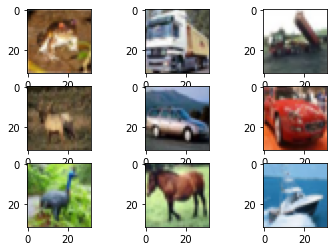

In [0]:
for i in range(0,9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(train_features[i])
# show the figure
plt.show()


In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'test'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'test'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = tf.keras.layers.Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = tf.keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = tf.keras.layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = tf.keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = tf.keras.layers.Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = tf.keras.layers.Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = tf.keras.layers.AveragePooling2D(pool_size=8)(x)
    y = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
with tf.device('/device:GPU:0'):
  # # Define the model
  # model = resnet_v1(input_shape=input_shape, depth=depth)
  if version == 2:
      model = resnet_v2(input_shape=input_shape, depth=depth)
  else:
      model = resnet_v1(input_shape=input_shape, depth=depth)
  model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule(0)),
                metrics=['accuracy'])
print(model_type)

Learning rate:  0.001
ResNet32v1


In [0]:
epochs = 200
batch_size = 32

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_ResNet32_model.{epoch:03d}.h5' #'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Train the model
start = time.time()
# 200 epochs
model_info = model.fit(train_features, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(test_features, test_labels),
          shuffle=True,
          callbacks=callbacks)
end = time.time()
print ("Model took "+str((end - start)/60)+" minutes to train")

Learning rate:  0.001
Epoch 1/25
1563/1563 [==============================] - 27s 17ms/step - loss: 1.6288 - accuracy: 0.5037 - val_loss: 1.9711 - val_accuracy: 0.4431 - lr: 0.0010
Learning rate:  0.001
Epoch 2/25
1563/1563 [==============================] - 26s 17ms/step - loss: 1.1616 - accuracy: 0.6727 - val_loss: 1.1846 - val_accuracy: 0.6633 - lr: 0.0010
Learning rate:  0.001
Epoch 3/25
1563/1563 [==============================] - 26s 17ms/step - loss: 0.9813 - accuracy: 0.7379 - val_loss: 1.5303 - val_accuracy: 0.5787 - lr: 0.0010
Learning rate:  0.001
Epoch 4/25
1563/1563 [==============================] - 26s 17ms/step - loss: 0.8824 - accuracy: 0.7718 - val_loss: 1.2357 - val_accuracy: 0.6649 - lr: 0.0010
Learning rate:  0.001
Epoch 5/25
1563/1563 [==============================] - 26s 17ms/step - loss: 0.8120 - accuracy: 0.7989 - val_loss: 1.0942 - val_accuracy: 0.7206 - lr: 0.0010
Learning rate:  0.001
Epoch 6/25
1563/1563 [==============================] - 26s 17ms/step - l

In [0]:
scores = model.evaluate(test_features, test_labels, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 2s 6ms/step - loss: 1.0909 - accuracy: 0.7862
Test loss: 1.0908987522125244
Test accuracy: 0.7861999869346619


Accuracy on test data is:78.62


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


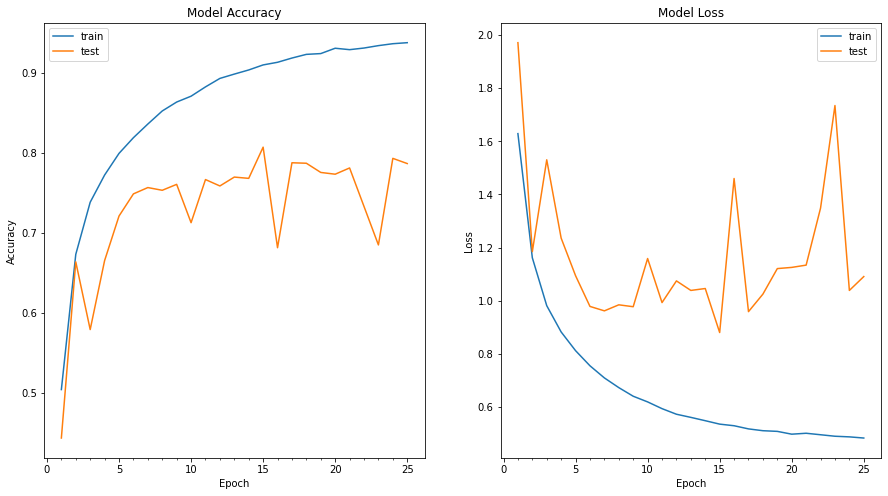

In [0]:
# compute test accuracy
print ("Accuracy on test data is:" + str(accuracy(test_features, test_labels, model)))
# plot model history
plot_model_history(model_info)

In [0]:
 model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
class_names = ['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']

In [0]:
y_pred = model.predict(test_features)

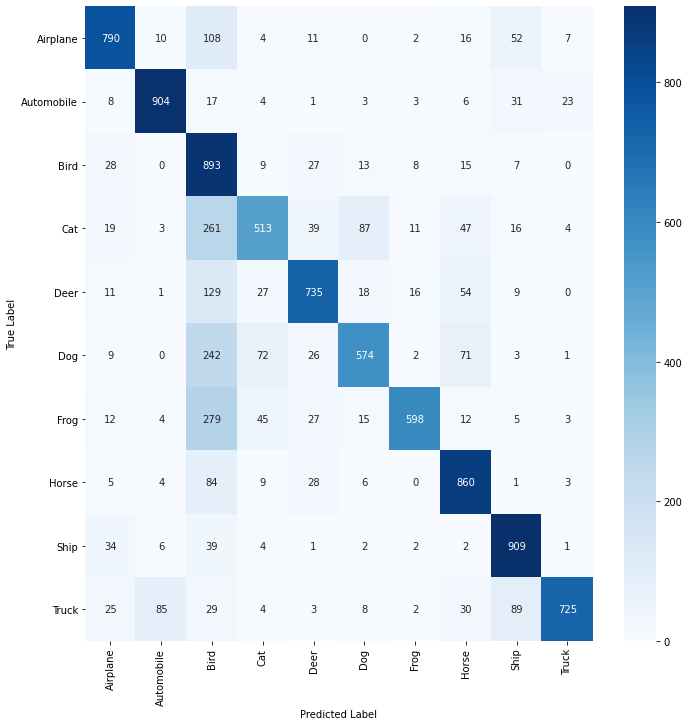

In [0]:
confusion_matrix = tf.math.confusion_matrix(labels=tf.argmax(test_labels,1), predictions=tf.argmax(y_pred,1)).numpy()
confusion_mat_df = pd.DataFrame(confusion_matrix, index=class_names, columns = class_names)
# print(confusion_mat_df)
figure = plt.figure(figsize=(10, 10))
sns.heatmap(confusion_mat_df, annot=True,fmt="d", cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

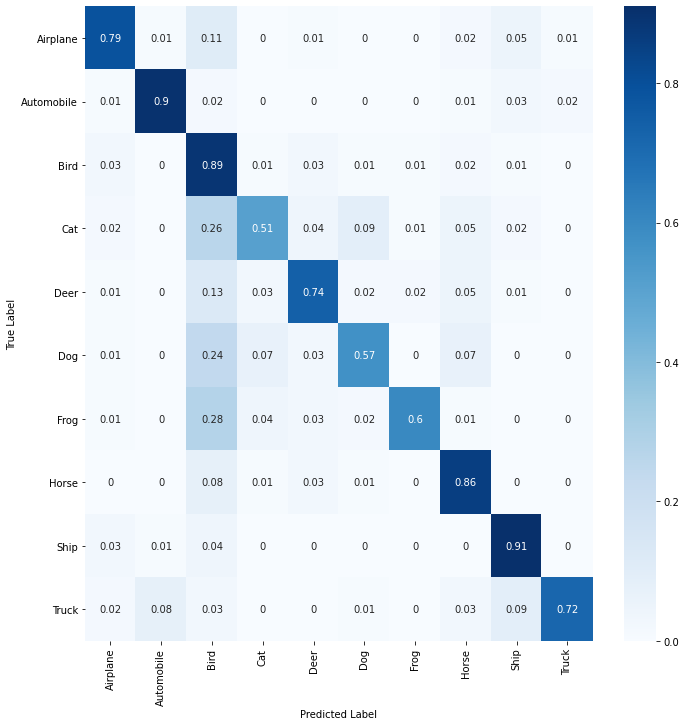

In [0]:
confusion_matrix = tf.math.confusion_matrix(labels=tf.argmax(test_labels,1), predictions=tf.argmax(y_pred,1)).numpy()
confusion_mat_norm = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:,np.newaxis], decimals=2)
confusion_mat_df = pd.DataFrame(confusion_mat_norm, index=class_names, columns = class_names)
# print(confusion_mat_df)
figure = plt.figure(figsize=(10, 10))
sns.heatmap(confusion_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [0]:
top1 = 0.0
top5 = 0.0    
class_probs = model.predict(test_features)
for i, l in enumerate(test_features):
    class_prob = class_probs[i]
    top_values = (-class_prob).argsort()[:5]
    if top_values[0] == l.any():
        top1 += 1.0
    if np.isin(np.array([l]).any(), top_values):
        top5 += 1.0

print("top1 acc", top1/len(test_features))
print("top5 acc", top5/len(test_features))

top1 acc 0.1017
top5 acc 0.3316
